In [ ]:
!pip install simpy
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, pow
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 12})

In [ ]:
# Constants
NUM_SERVERS_DEFAULT = 10               # Default number of servers (k) for M/M/k
ARRIVAL_RATE_DEFAULT = 1               # Mean inter-arrival time for general arrivals (seconds)
SERVICE_RATE_DEFAULT = 0.5             # Mean service time for general services (seconds)
SIMULATION_TIME = 200                   # Simulation duration in seconds
ENERGY_BASE = 100                       # Base energy usage (watts per server)
ENERGY_PER_UTILIZATION = 50             # Additional energy usage (watts) per utilization


In [ ]:
# Metrics tracking
class Metrics:
    def __init__(self):
        self.latency = []              # Latency for each request
        self.waiting_time = []         # Waiting time for each request
        self.queue_lengths = []        # Queue length over time
        self.server_utilization = []   # Server utilization over time
        self.energy_consumption = []   # Energy consumption over time


In [ ]:
# Request object
class Request:
    def __init__(self, arrival_time, service_time, priority=0):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.priority = priority
        self.start_service_time = None

In [ ]:
# Queuing Manager with Multiple Algorithms
class QueueManager:
    def __init__(self, algorithm='FCFS'):
        self.queue = []
        self.algorithm = algorithm

    def add_request(self, request):
        if self.algorithm == 'FCFS':
            self.queue.append(request)
        elif self.algorithm == 'SJF':
            self.queue.append(request)
            self.queue.sort(key=lambda r: r.service_time)  # Sort by shortest service time
        elif self.algorithm == 'Priority':
            self.queue.append(request)
            self.queue.sort(key=lambda r: r.priority, reverse=True)  # Sort by priority (higher first)

    def pop_request(self):
        if self.queue:
            return self.queue.pop(0)
        return None

# Arrival and Service Functions

In [ ]:
# Poisson Arrival
def arrival_time_poisson(rate):
    return random.expovariate(rate)


In [ ]:
# General Arrival (e.g., Uniform)
def arrival_time_general(rate):
    # Assuming 'rate' is the mean inter-arrival time for uniform distribution
    return random.uniform(rate / 2, 3 * rate / 2)


In [ ]:
# Memoryless Service Time (Exponential)
def service_time_memoryless(rate):
    return random.expovariate(rate)


In [ ]:
# General Service Time (e.g., Deterministic or Uniform)
def service_time_general(rate):
    # Assuming 'rate' is the mean service time for uniform distribution
    return random.uniform(rate / 2, 3 * rate / 2)

In [ ]:
# Theoretical M/M/k Calculations
def theoretical_mm_k(lambda_rate, mu_rate, k):
    rho = lambda_rate / (k * mu_rate)
    if rho >= 1:
        print("System is unstable (rho >= 1).")
        return None

    # Calculate P0
    sum_terms = sum([(pow(lambda_rate / mu_rate, n) / factorial(n)) for n in range(k)])
    last_term = (pow(lambda_rate / mu_rate, k) / (factorial(k) * (1 - rho)))
    P0 = 1 / (sum_terms + last_term)

    # Calculate Lq
    Lq = (pow(lambda_rate / mu_rate, k) * rho) / (factorial(k) * pow(1 - rho, 2)) * P0

    # Calculate Wq
    Wq = Lq / lambda_rate

    # Calculate L (Average number of jobs in system)
    L = Lq + (lambda_rate / mu_rate)

    # Calculate W (Average time a job spends in system)
    W = Wq + (1 / mu_rate)

    # Utilization
    utilization = rho

    return {
        'P0': P0,
        'Lq': Lq,
        'Wq': Wq,
        'L': L,
        'W': W,
        'Utilization': utilization
    }

In [ ]:
# Handle Each Request
def handle_request(env, servers, metrics, queue_manager):
    with servers.request() as request:
        req = queue_manager.pop_request()
        if req:
            yield request  # Wait for server to become available
            req.start_service_time = env.now
            waiting_time = req.start_service_time - req.arrival_time
            metrics.waiting_time.append(waiting_time)
            if waiting_time > 0:
                print(f"Time {env.now:.4f}: Request waited {waiting_time:.4f} seconds.")
            yield env.timeout(req.service_time)  # Service time
            latency = env.now - req.arrival_time
            metrics.latency.append(latency)


In [ ]:
# LLM Inference System
def llm_inference(env, servers, arrival_func, service_func, metrics, queue_manager):
    while True:
        inter_arrival = arrival_func()
        yield env.timeout(inter_arrival)  # Generate arrival
        service_time = service_func()
        priority = random.randint(1, 10)  # Assign random priority
        request = Request(env.now, service_time, priority)
        queue_manager.add_request(request)
        env.process(handle_request(env, servers, metrics, queue_manager))

In [ ]:
# Monitor System State
def monitor(env, servers, metrics, interval=1):
    while True:
        yield env.timeout(interval)
        queue_length = len(servers.queue)
        metrics.queue_lengths.append(queue_length)

        # Calculate server utilization
        busy_servers = servers.count
        utilization = busy_servers / servers.capacity
        metrics.server_utilization.append(utilization)

        # Energy consumption: Static + Dynamic
        total_energy = servers.capacity * ENERGY_BASE + servers.capacity * utilization * ENERGY_PER_UTILIZATION
        metrics.energy_consumption.append(total_energy)

In [ ]:
# Simulate Queuing System
def simulate_queuing_system(queue_type, algorithm, arrival_func, service_func, lambda_rate, mu_rate, k):
    metrics = Metrics()
    queue_manager = QueueManager(algorithm=algorithm)
    env = simpy.Environment()

    # Determine number of servers based on queue_type
    if queue_type in ["M/M/1", "G/G/1", "G/M/1", "M/G/1"]:
        servers = simpy.Resource(env, capacity=1)
    elif queue_type == "M/M/k":
        servers = simpy.Resource(env, capacity=k)
    else:
        raise ValueError(f"Unsupported queue type: {queue_type}")

    env.process(llm_inference(env, servers, arrival_func, service_func, metrics, queue_manager))
    env.process(monitor(env, servers, metrics))
    env.run(until=SIMULATION_TIME)
    return metrics

In [ ]:
# Define Different Queuing Systems
queuing_systems = {
    "M/M/1": (lambda: arrival_time_poisson(ARRIVAL_RATE_DEFAULT), lambda: service_time_memoryless(SERVICE_RATE_DEFAULT), 1),
    "M/M/k": (lambda: arrival_time_poisson(ARRIVAL_RATE_DEFAULT), lambda: service_time_memoryless(SERVICE_RATE_DEFAULT), NUM_SERVERS_DEFAULT),
    "G/G/1": (lambda: arrival_time_general(1), lambda: service_time_general(0.5), 1),
    "G/M/1": (lambda: arrival_time_general(1), lambda: service_time_memoryless(SERVICE_RATE_DEFAULT), 1),
    "M/G/1": (lambda: arrival_time_poisson(ARRIVAL_RATE_DEFAULT), lambda: service_time_general(0.5), 1),
}

In [ ]:
# Run and Store Results for Each Queuing System and Scheduling Algorithm
scheduling_algorithms = ['FCFS', 'SJF', 'Priority']
results = {}

for queue_type, (arrival_func, service_func, k) in queuing_systems.items():
    for algo in scheduling_algorithms:
        print(f"Simulating {queue_type} with {algo} scheduling...")
        metrics = simulate_queuing_system(
            queue_type=queue_type,
            algorithm=algo,
            arrival_func=arrival_func,
            service_func=service_func,
            lambda_rate=ARRIVAL_RATE_DEFAULT,
            mu_rate=SERVICE_RATE_DEFAULT,
            k=k
        )
        # Store results in a nested dictionary
        if queue_type not in results:
            results[queue_type] = {}
        results[queue_type][algo] = metrics

Simulating M/M/1 with FCFS scheduling...
Time 3.2000: Request waited 0.7585 seconds.
Time 10.8035: Request waited 2.8427 seconds.
Time 14.5622: Request waited 6.2382 seconds.
Time 27.3028: Request waited 18.8870 seconds.
Time 28.3392: Request waited 18.2904 seconds.
Time 30.3464: Request waited 20.1756 seconds.
Time 30.7961: Request waited 19.8281 seconds.
Time 32.0596: Request waited 18.1469 seconds.
Time 32.5827: Request waited 18.1160 seconds.
Time 32.8291: Request waited 16.4695 seconds.
Time 34.9144: Request waited 15.6373 seconds.
Time 35.6382: Request waited 15.7020 seconds.
Time 36.4265: Request waited 16.2197 seconds.
Time 38.0748: Request waited 14.7246 seconds.
Time 42.1798: Request waited 17.0657 seconds.
Time 42.2659: Request waited 12.2623 seconds.
Time 43.3088: Request waited 12.9777 seconds.
Time 43.6032: Request waited 12.0410 seconds.
Time 44.5611: Request waited 11.4001 seconds.
Time 45.1171: Request waited 11.6297 seconds.
Time 46.9257: Request waited 12.8986 second

In [ ]:
# Compute Theoretical Metrics for M/M/1 and M/M/k (Only FCFS)
theoretical_metrics = {}
for queue_type in ["M/M/1", "M/M/k"]:
    theoretical = theoretical_mm_k(ARRIVAL_RATE_DEFAULT, SERVICE_RATE_DEFAULT, queuing_systems[queue_type][2])
    if theoretical:
        theoretical_metrics[queue_type] = theoretical


System is unstable (rho >= 1).


In [ ]:
# Visualization Function
def plot_comparative_metrics(results, theoretical_metrics):
    for queue_type, algos in results.items():
        plt.figure(figsize=(20, 24))
        plt.suptitle(f"Comparative Analysis for {queue_type} Queuing System", fontsize=20)

        # Latency Distribution
        plt.subplot(4, 1, 1)
        for algo, metrics in algos.items():
            sns.kdeplot(metrics.latency, label=algo, fill=True, alpha=0.3)
        plt.title("Latency Distribution")
        plt.xlabel("Latency (s)")
        plt.ylabel("Density")
        plt.legend()

        # Queue Length Over Time
        plt.subplot(4, 1, 2)
        for algo, metrics in algos.items():
            plt.plot(range(len(metrics.queue_lengths)), metrics.queue_lengths, label=algo)
        plt.title("Queue Length Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Queue Length")
        plt.legend()

        # Server Utilization Over Time
        plt.subplot(4, 1, 3)
        for algo, metrics in algos.items():
            plt.plot(range(len(metrics.server_utilization)), metrics.server_utilization, label=algo)
        plt.title("Server Utilization Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Utilization")
        plt.ylim(0, 1)
        plt.legend()

        # Energy Consumption Over Time
        plt.subplot(4, 1, 4)
        for algo, metrics in algos.items():
            plt.plot(range(len(metrics.energy_consumption)), metrics.energy_consumption, label=algo)
        plt.title("Energy Consumption Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Energy Consumption (W)")
        plt.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # If theoretical metrics are available, add them to the plots
        if queue_type in theoretical_metrics and 'FCFS' in algos:
            theo = theoretical_metrics[queue_type]
            print(f"\nTheoretical Metrics for {queue_type} (FCFS):")
            for key, value in theo.items():
                if key == 'Utilization':
                    print(f"{key}: {value:.4f}")
                else:
                    print(f"{key}: {value:.4f} units")
            # Compare theoretical with simulation for FCFS
            sim = algos['FCFS']
            avg_waiting_time_sim = np.mean(sim.waiting_time) if sim.waiting_time else float('inf')
            avg_latency_sim = np.mean(sim.latency) if sim.latency else float('inf')
            utilization_sim = np.mean(sim.server_utilization) if sim.server_utilization else float('inf')

            print(f"\nComparison Between Theoretical and Simulation Metrics ({queue_type} - FCFS):")
            print(f"{'Metric':<25}{'Theoretical':<20}{'Simulation':<20}")
            print(f"{'-'*65}")
            print(f"{'Average Waiting Time (Wq)':<25}{theo['Wq']:<20.4f}{avg_waiting_time_sim:<20.4f}")
            print(f"{'Average Latency (W)':<25}{theo['W']:<20.4f}{avg_latency_sim:<20.4f}")
            print(f"{'Utilization (ρ)':<25}{theo['Utilization']:<20.4f}{utilization_sim:<20.4f}")


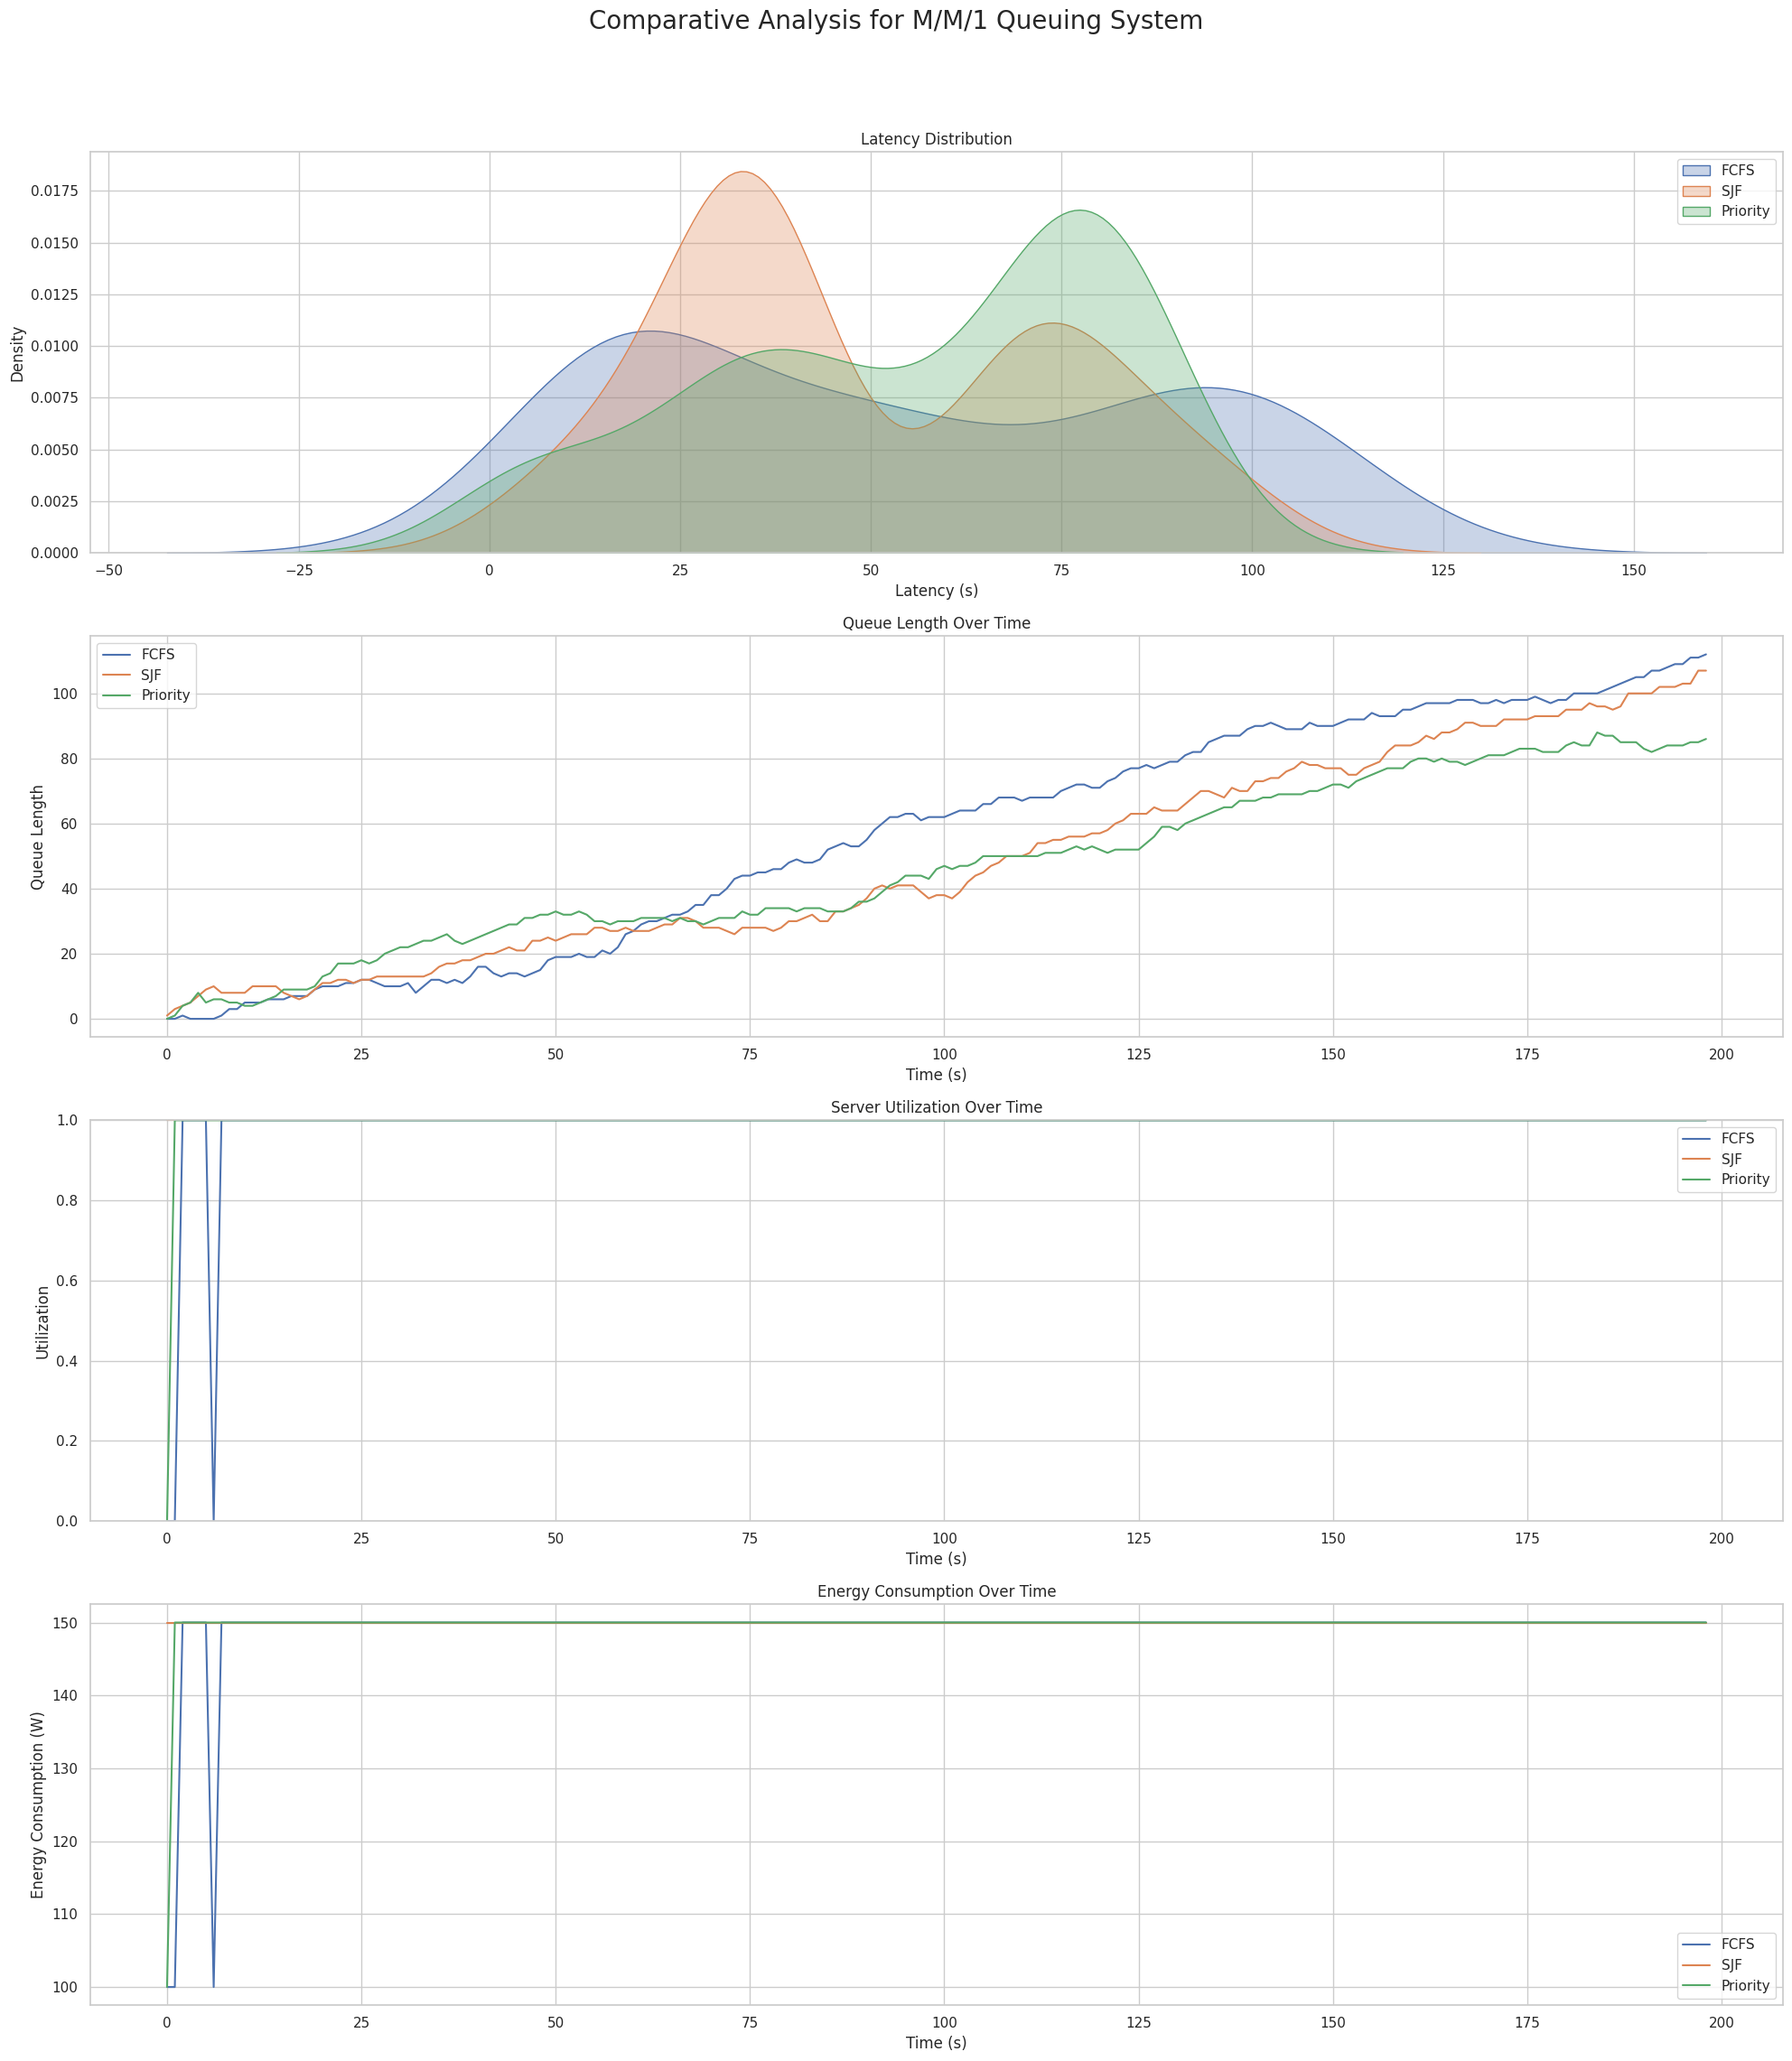

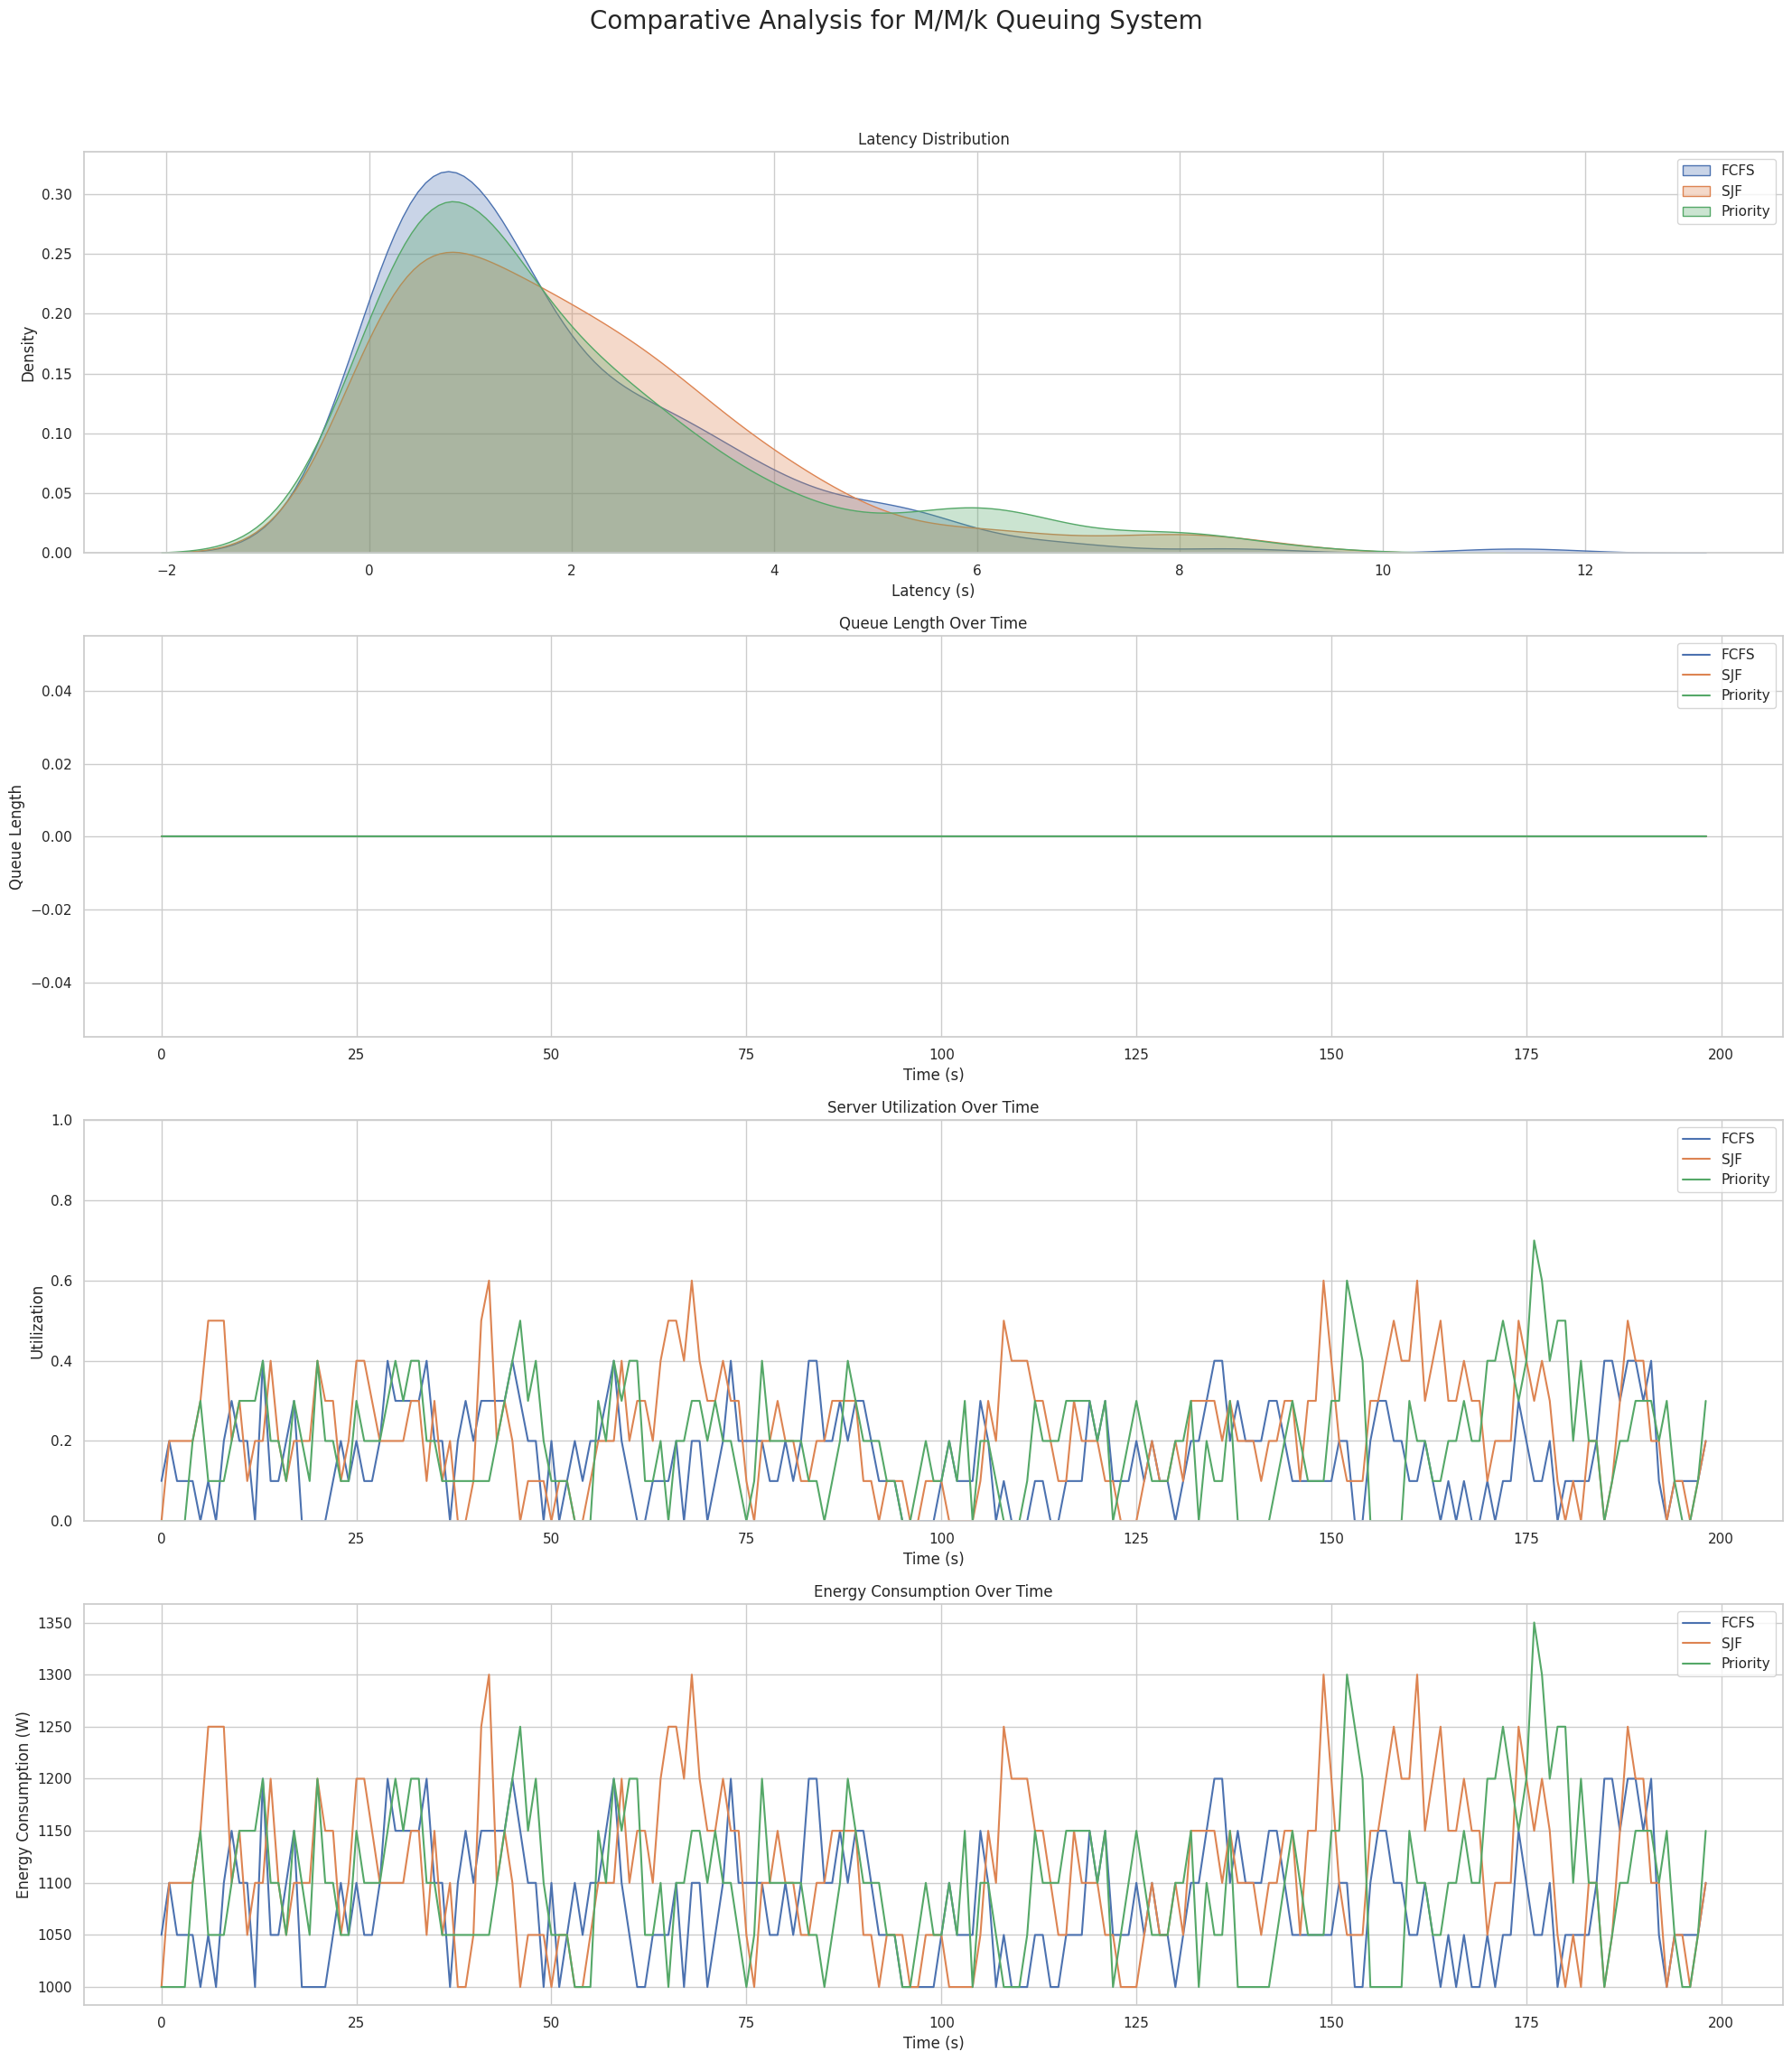


Theoretical Metrics for M/M/k (FCFS):
P0: 0.1353 units
Lq: 0.0000 units
Wq: 0.0000 units
L: 2.0000 units
W: 2.0000 units
Utilization: 0.2000

Comparison Between Theoretical and Simulation Metrics (M/M/k - FCFS):
Metric                   Theoretical         Simulation          
-----------------------------------------------------------------
Average Waiting Time (Wq)0.0000              0.0000              
Average Latency (W)      2.0000              1.7971              
Utilization (ρ)          0.2000              0.1608              


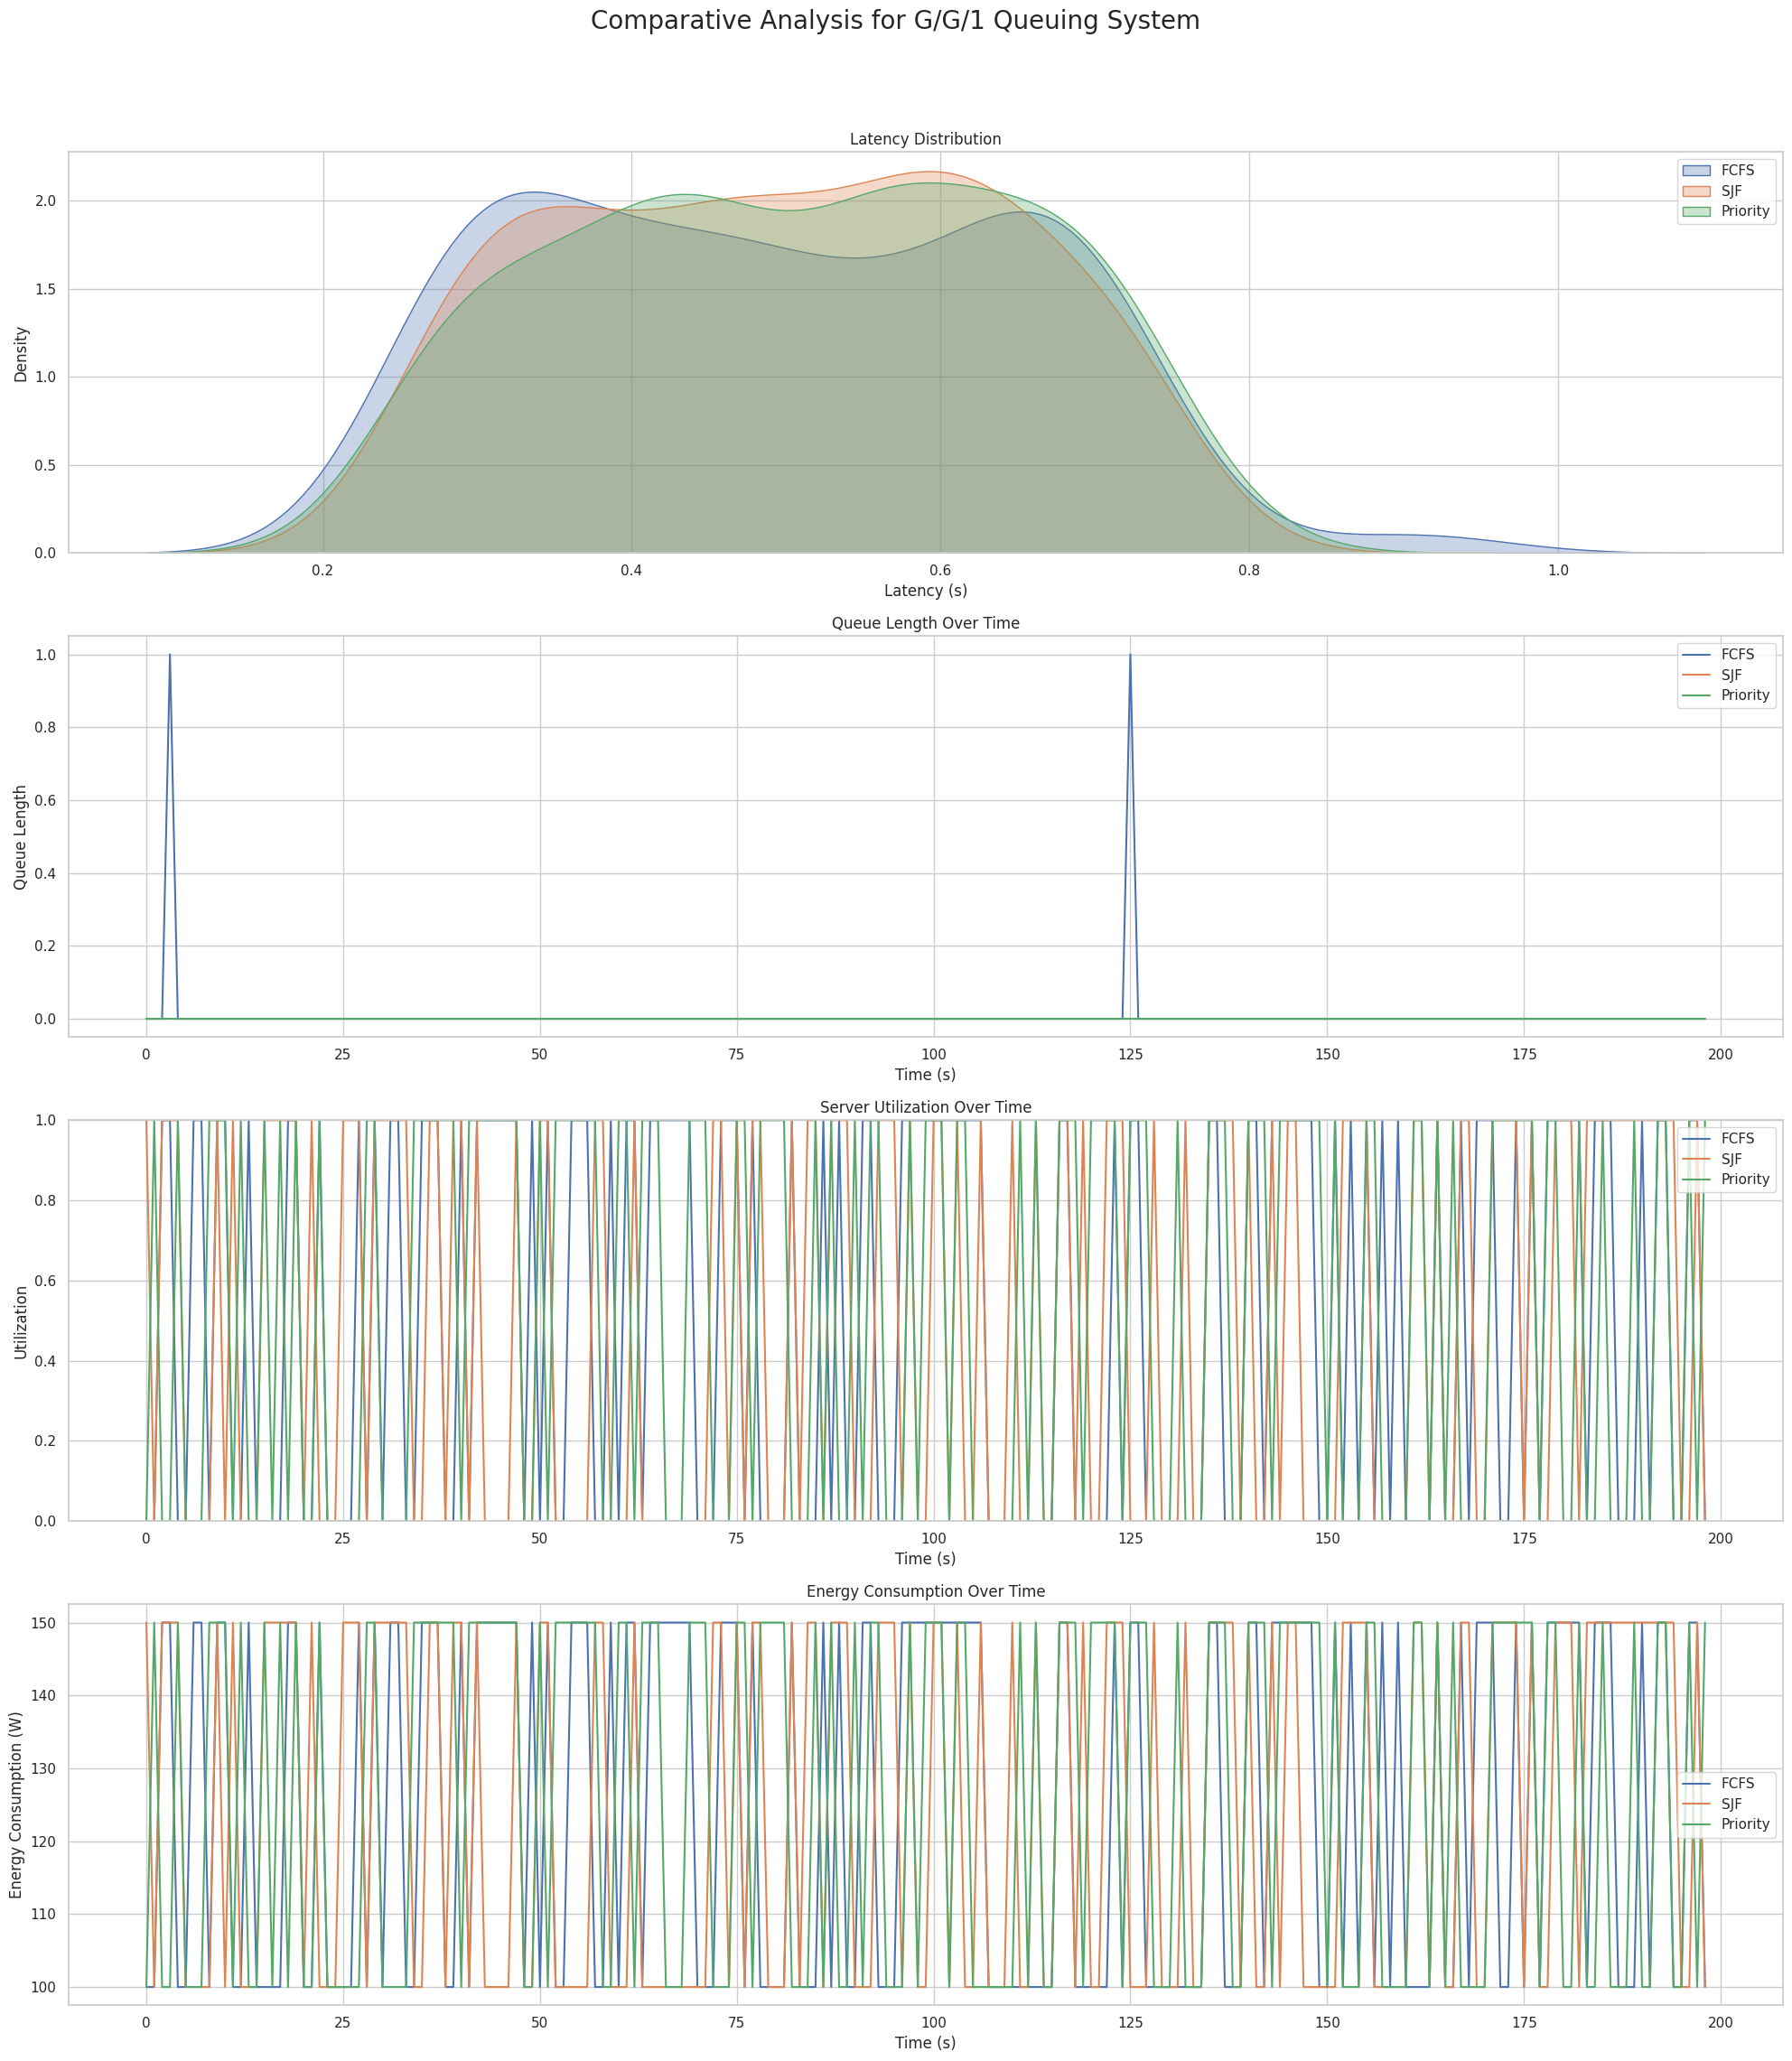

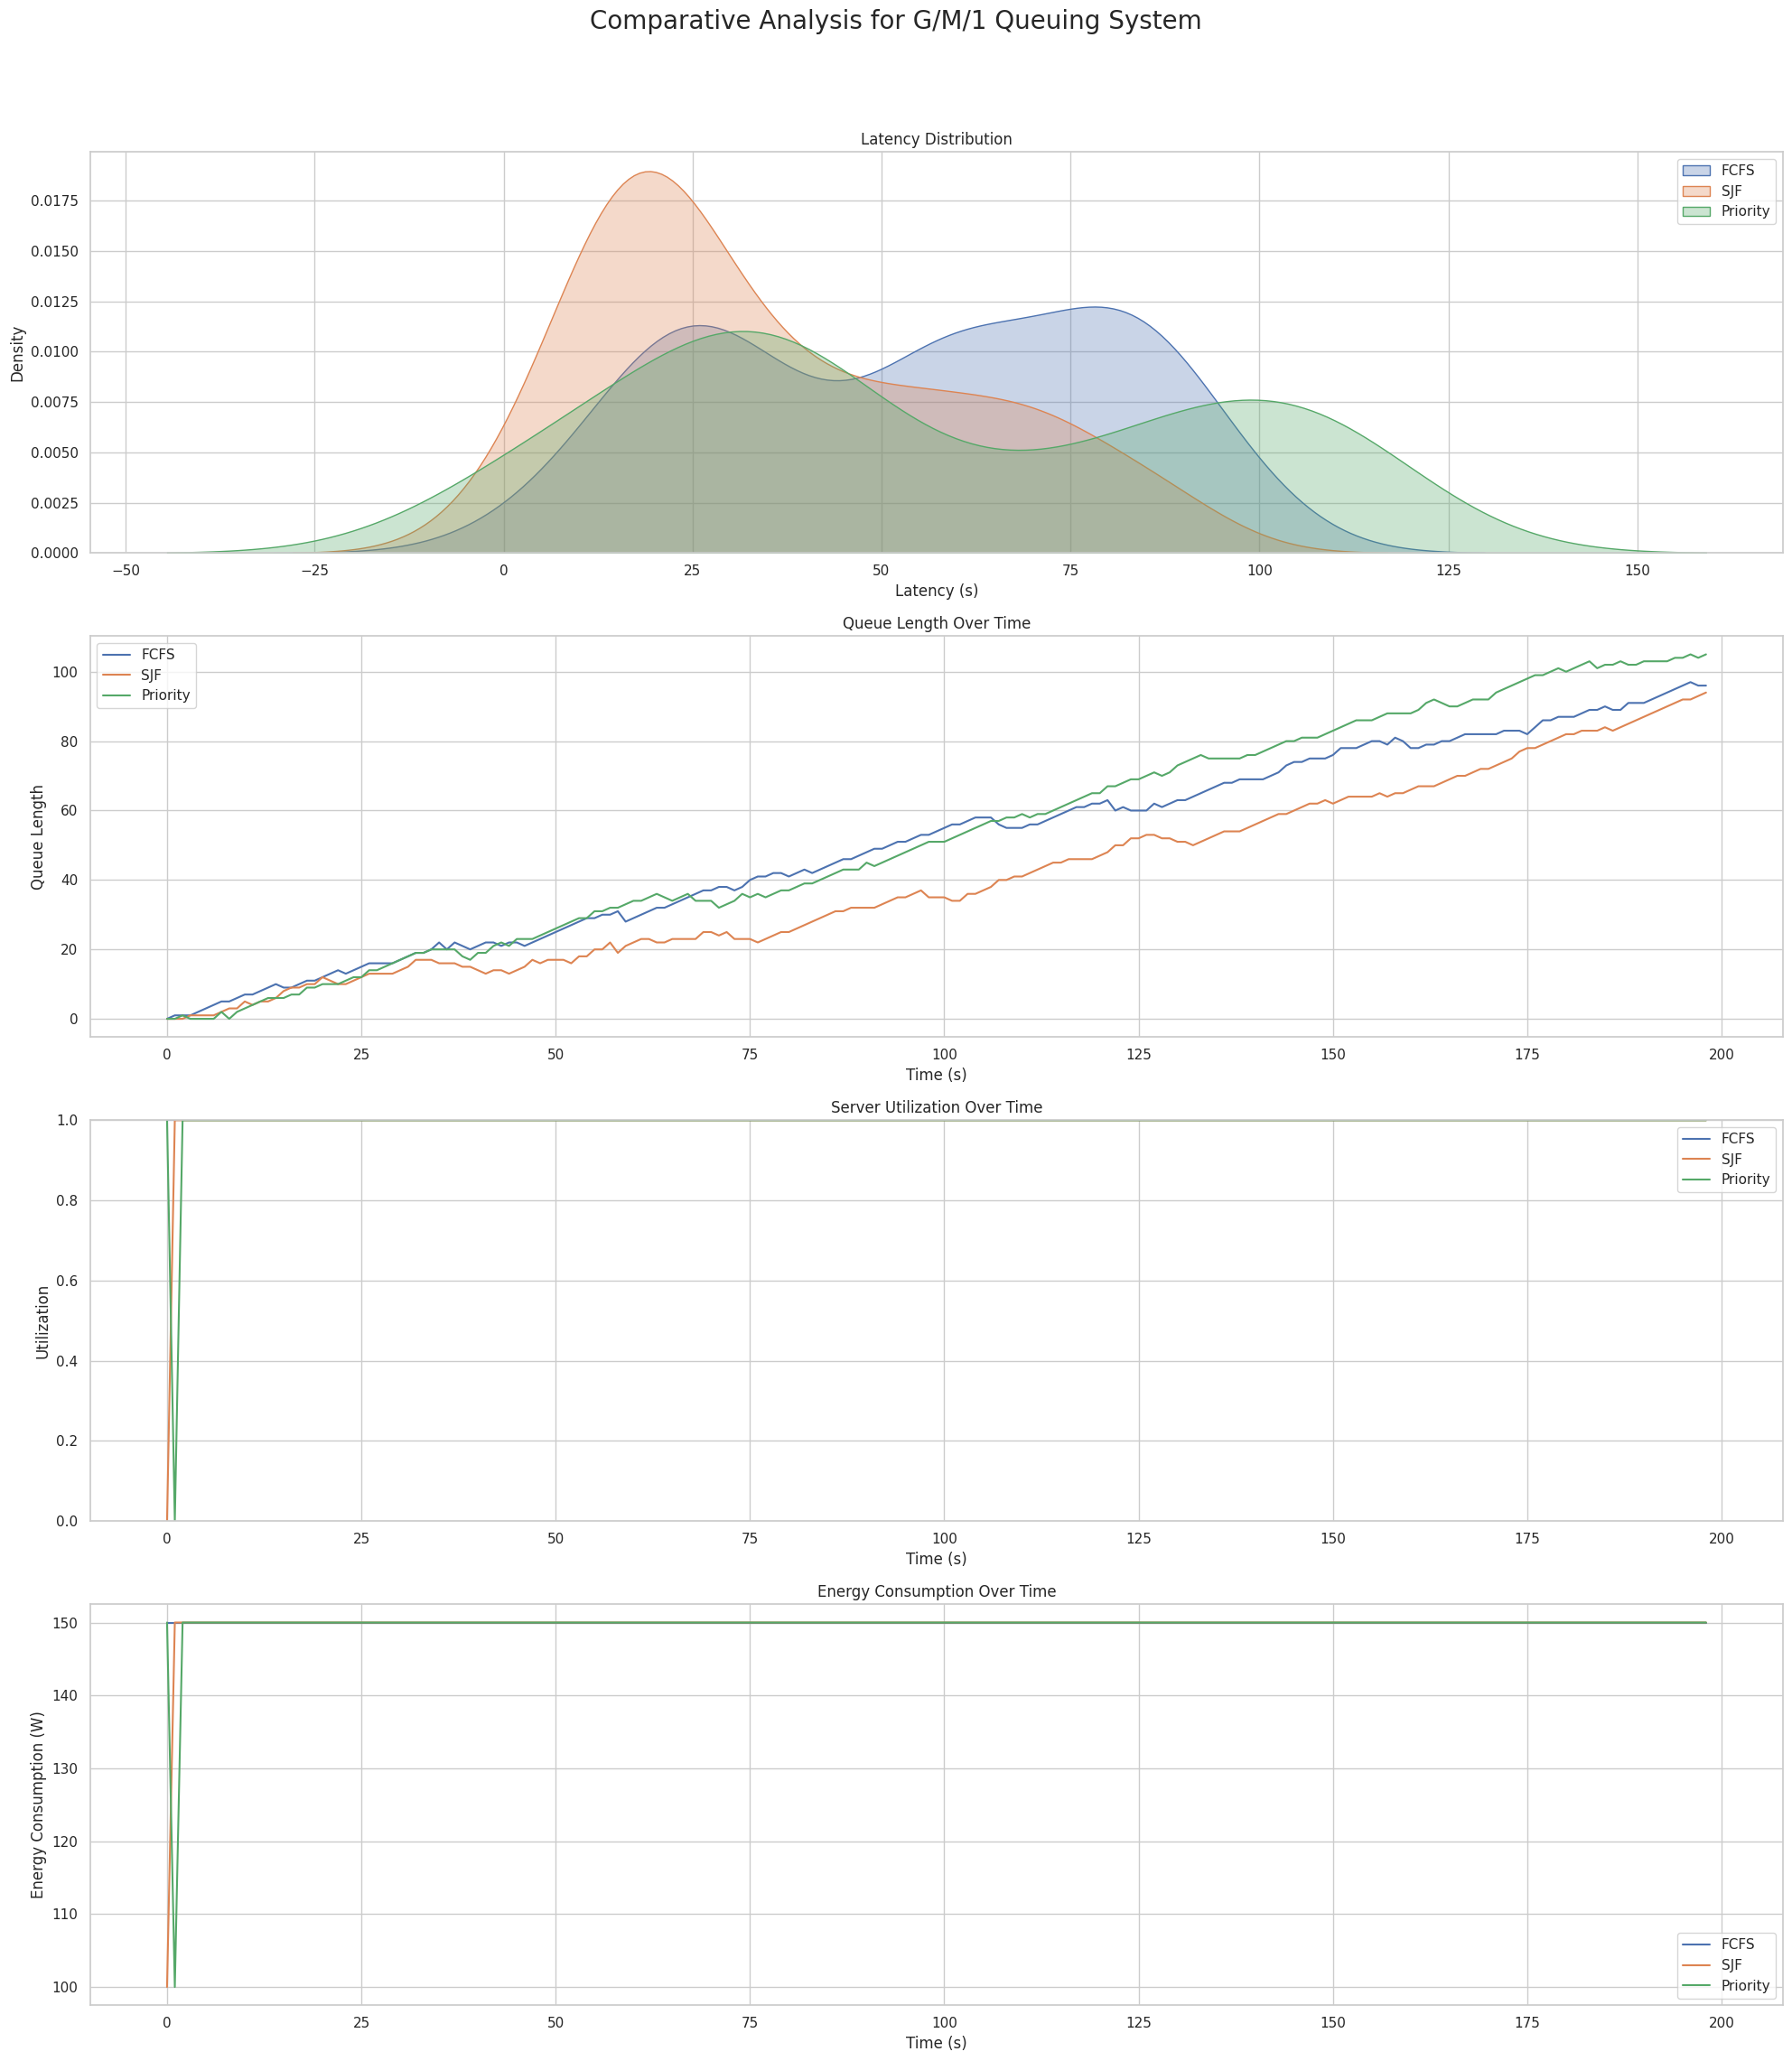

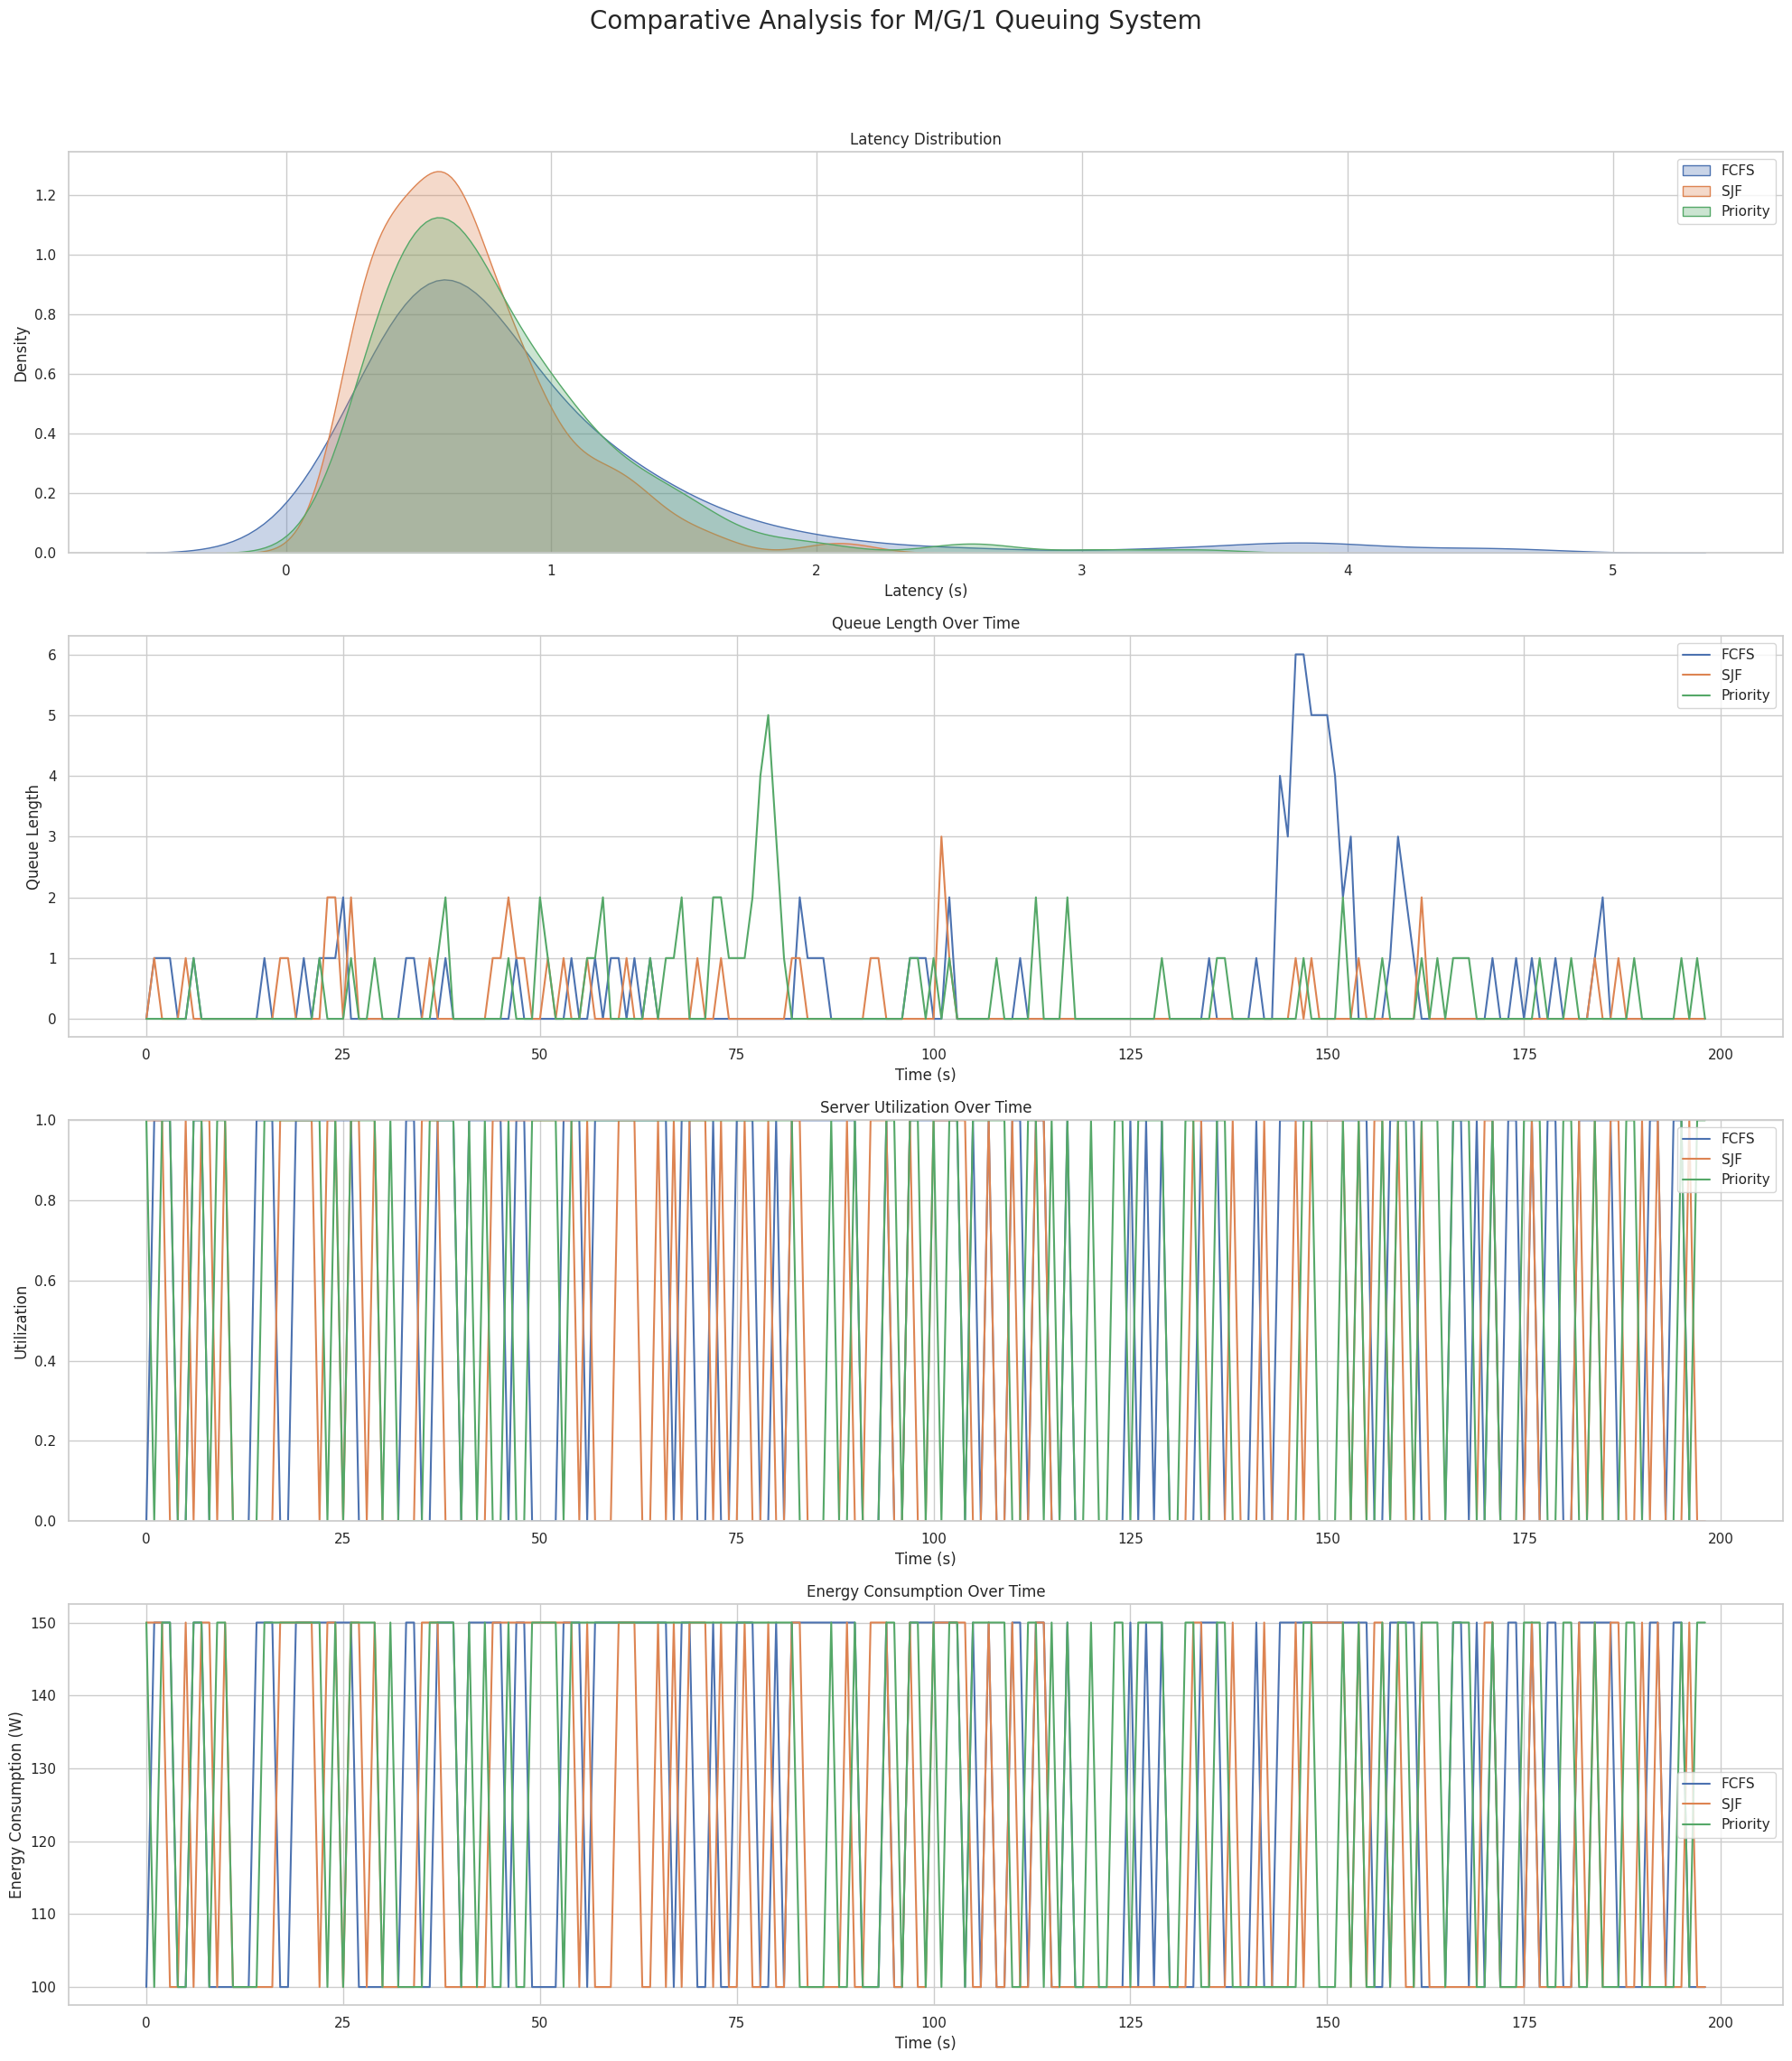

In [ ]:
plot_comparative_metrics(results, theoretical_metrics)

In [ ]:
# Summary Table of Metrics
def print_summary_table(results):
    print("\nAverage Waiting Time and Latency for All Queuing Systems and Scheduling Algorithms:")
    print(f"{'Queue Type':<10}{'Algorithm':<10}{'Avg Waiting Time (s)':<25}{'Avg Latency (s)':<20}")
    print(f"{'-'*65}")
    for queue_type, algos in results.items():
        for algo, metrics in algos.items():
            avg_waiting_time = np.mean(metrics.waiting_time) if metrics.waiting_time else float('inf')
            avg_latency = np.mean(metrics.latency) if metrics.latency else float('inf')
            print(f"{queue_type:<10}{algo:<10}{avg_waiting_time:<25.4f}{avg_latency:<20.4f}")


In [ ]:
print_summary_table(results)


Average Waiting Time and Latency for All Queuing Systems and Scheduling Algorithms:
Queue TypeAlgorithm Avg Waiting Time (s)     Avg Latency (s)     
-----------------------------------------------------------------
M/M/1     FCFS      52.2390                  53.8306             
M/M/1     SJF       47.2599                  48.8796             
M/M/1     Priority  53.9874                  55.6347             
M/M/k     FCFS      0.0000                   1.7971              
M/M/k     SJF       0.0000                   2.0782              
M/M/k     Priority  0.0000                   2.0051              
G/G/1     FCFS      0.0062                   0.4955              
G/G/1     SJF       0.0049                   0.4988              
G/G/1     Priority  0.0065                   0.5072              
G/M/1     FCFS      52.3222                  53.8394             
G/M/1     SJF       34.4821                  35.8623             
G/M/1     Priority  53.3958                  55.0227     